In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# 'cs231n' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'cs231n/assignments/assignment1/cs231n/'
FOLDERNAME = 'CS231N/assignments/assignment1/cs231n/'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd /content/drive/My \Drive
%cp -r $FOLDERNAME ../../
%cd ../../
%cd cs231n/datasets/
!bash get_datasets.sh
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content
/content/cs231n/datasets
--2022-02-11 09:07:10--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  89.6MB/s    in 1.8s    

2022-02-11 09:07:12 (89.6 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content


# Image features exercise
*Заполните и передайте этот заполненный рабочий лист (включая его результаты и любой вспомогательный код за пределами рабочего листа) вместе с отправкой задания. Дополнительные сведения см. на [странице заданий](http://vision.stanford.edu/teaching/cs231n/assignments.html) на веб-сайте курса.*

Мы видели, что мы можем добиться разумной эффективности в задаче классификации изображений, обучив линейный классификатор на пикселях входного изображения. В этом упражнении мы покажем, что можем повысить эффективность нашей классификации, обучая линейные классификаторы не на необработанных пикселях, а признаках, вычисляемых на основе необработанных пикселей.

Вся ваша работа по этому упражнению будет выполняться в этой тетради.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Как и в предыдущих упражнениях, мы будем загружать данные CIFAR-10 с диска.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features

Для каждого изображения мы вычислим гистограмму ориентированных градиентов (HOG), а также цветовую гистограмму с использованием канала оттенка в цветовом пространстве HSV. Мы формируем наш окончательный вектор признаков для каждого изображения, объединяя векторы признаков HOG и цветовой гистограммы.

Грубо говоря, HOG должен фиксировать текстуру изображения, игнорируя информацию о цвете, а цветовая гистограмма представляет цвет входного изображения, игнорируя текстуру. В результате мы ожидаем, что использование обоих вместе должно работать лучше, чем использование каждого из них по отдельности. Было бы неплохо проверить это предположение в собственных интересах.

Функции `hog_feature` и `color_histogram_hsv` работают с одним изображением и возвращают вектор признаков для этого изображения. Функция Extract_features берет набор изображений и список функций признаков и оценивает каждую функцию признаков на каждом изображении, сохраняя результаты в матрице, где каждый столбец представляет собой объединение всех векторов признаков для одного изображения.

In [4]:
from cs231n.features import *

num_color_bins = 16 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Используя мультиклассовый код SVM, разработанный ранее в задании, обучите SVM на основе извлеченных выше признаков; это должно дать лучшие результаты, чем обучение SVM непосредственно поверх необработанных пикселей.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

grid = [(lr,rs) for lr in learning_rates for rs in regularization_strengths]
for lr, rs in grid:
  # кросс-валидация c 1 проверочным набором размером 1000. Сортировка svm по best_val
  
  svm = LinearSVM() # инициализация
  svm.train(X_train_feats,y_train,lr,rs, num_iters = 500) # batch_size = 200
  y_val_predict = svm.predict(X_val_feats)
  y_train_predict = svm.predict(X_train_feats)
  train_acc = np.mean(y_train_predict == y_train)
  val_acc = np.mean(y_val_predict == y_val)

  if(best_val < val_acc):
    best_svm = svm
    best_val = val_acc

  results[(lr,rs)] = [train_acc,val_acc]

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.124673 val accuracy: 0.123000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.109816 val accuracy: 0.110000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.084796 val accuracy: 0.101000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.096408 val accuracy: 0.086000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.119673 val accuracy: 0.116000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.413735 val accuracy: 0.411000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.233571 val accuracy: 0.229000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.416041 val accuracy: 0.414000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.320939 val accuracy: 0.326000
best validation accuracy achieved during cross-validation: 0.414000


In [6]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.417


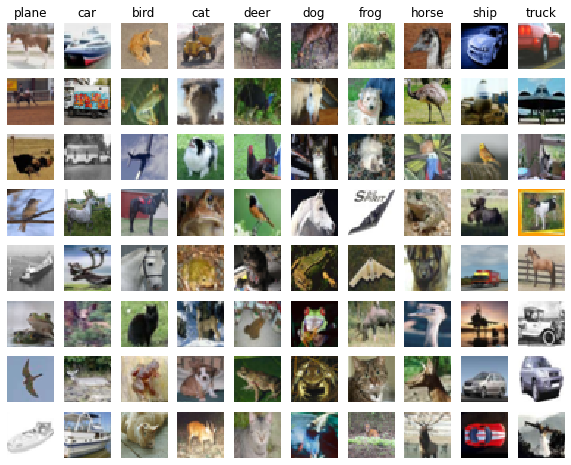

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Опишите результаты неправильной классификации, которые вы видите. Имеют ли они смысл?


$\color{blue}{\textit Your Answer:}$ Заметно, что большинство неверно классифицированных изображений для какого-то конкретного класса принадлежат к другому конкретному классу. То есть не наблюдается случайность в неверно классифицированных изображениях. Так, например если рассмотреть неверно классифицировавнные изображения для класса `plane` то заметно преобладание изображений класса `ship`. Это же аналогично и для неверно классифицированных изображений помеченных как `plane`. Это следстввие похожего фона (так как в признаках содержится информация о цвете). Также заметно, что некоторые изображения грузовиков помечены как `car`. Это вследствие большой схожести изображений этих классов.


## Neural Network on image features
Ранее в этом задании мы видели, что обучение двухслойной нейронной сети на необработанных пикселях обеспечивает более высокую эффективность классификации, чем линейные классификаторы на необработанных пикселях. В этой записной книжке мы увидели, что линейные классификаторы на функциях изображения превосходят линейные классификаторы на необработанных пикселях.

Для полноты мы также должны попробовать обучить нейронную сеть на функциях изображения. Этот подход должен превзойти все предыдущие подходы: вы легко сможете достичь точности классификации более 55% на тестовом наборе; наша лучшая модель обеспечивает точность классификации около 60%.

In [8]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 161)
(49000, 160)


In [ ]:
np.hist(X_train_feats.ravel, 10)

In [36]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

def tuning_hyper_params(X_train, y_train, X_val, y_val, num_iters, batch_size):
  best_val = -1
  best_net_history = None
  tuning_history ={}
  best_net = None

  '''
  Оценка эффективности модели при опредленных гиперпараметрах будет производиться 
  на заданном заранее наборе ( 1000 шт без кросс валидации)
  '''
  input_dim = X_train.shape[1]

  hidden_layers_sizes = [100, 200, 300, 400]
  learning_rates = [0.5,0.05, 0.9]
  regularization_strengths = [1e-1, 1e-3, 1e-5, 0.25]
  
  grid = [(lsz,lr,rg) for lsz in hidden_layers_sizes for lr in learning_rates for rg in regularization_strengths ]
  print("Кол-во итераций по параметрам ", len(grid))
  i = 0
  j = 0
  for lsz,lr,rg in grid:
    i+=1
    if i % 10 == 0 :
      print("Выполняется %d/ %d итераций " % (i,len(grid)))
    net = TwoLayerNet(input_dim,lsz,10)
    result_train = net.train(X_train_feats, y_train, X_val_feats, y_val, lr, 0.95, rg, num_iters, batch_size, verbose = False)
    val_acc_history = result_train["val_acc_history"]
    if(best_val < max(val_acc_history)):
      best_val = max(val_acc_history)
      best_net = net
      best_net_history = result_train
      
    tuning_history[(lsz,lr,rg)] = [result_train["train_acc_history"][np.argmax(val_acc_history)],max(val_acc_history)]

  # Данные подбора гиперпараметров
  for key, value in sorted(tuning_history.items(), key= lambda val_acc : np.asarray(val_acc)[1][1], reverse = True):
    train_accuracy, val_accuracy = tuning_history[key]
    print('lsz %d lr %e reg %e train accuracy: %f val accuracy: %f' % (
                  key[0], key[1], key[2], value[0], value[1]))
    
  print('best validation accuracy achieved during cross-validation: %f' % best_val)

  # Визуализация
  plt.subplot(2, 1, 1)
  plt.plot(best_net_history['loss_history'])
  plt.title('Loss history')
  plt.xlabel('Iteration')
  plt.ylabel('Loss')

  plt.subplot(2, 1, 2)
  plt.plot(best_net_history['train_acc_history'], label='train')
  plt.plot(best_net_history['val_acc_history'], label='val')
  plt.title('Classification accuracy history')
  plt.xlabel('Epoch')
  plt.ylabel('Classification accuracy')
  plt.grid(True)
  plt.legend()
  plt.show()

  return tuning_history, best_net, best_net_history
  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


Кол-во итераций по параметрам  48
Выполняется 10/ 48 итераций 
Выполняется 20/ 48 итераций 
Выполняется 30/ 48 итераций 
Выполняется 40/ 48 итераций 


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


lsz 400 lr 9.000000e-01 reg 1.000000e-05 train accuracy: 0.888000 val accuracy: 0.618000
lsz 300 lr 9.000000e-01 reg 1.000000e-03 train accuracy: 0.824000 val accuracy: 0.613000
lsz 300 lr 5.000000e-01 reg 1.000000e-05 train accuracy: 0.762000 val accuracy: 0.612000
lsz 400 lr 9.000000e-01 reg 1.000000e-03 train accuracy: 0.800000 val accuracy: 0.611000
lsz 400 lr 5.000000e-01 reg 1.000000e-03 train accuracy: 0.728000 val accuracy: 0.609000
lsz 300 lr 5.000000e-01 reg 1.000000e-03 train accuracy: 0.758000 val accuracy: 0.607000
lsz 400 lr 5.000000e-01 reg 1.000000e-05 train accuracy: 0.778000 val accuracy: 0.605000
lsz 200 lr 5.000000e-01 reg 1.000000e-03 train accuracy: 0.706000 val accuracy: 0.600000
lsz 200 lr 5.000000e-01 reg 1.000000e-05 train accuracy: 0.784000 val accuracy: 0.600000
lsz 200 lr 9.000000e-01 reg 1.000000e-03 train accuracy: 0.770000 val accuracy: 0.599000
lsz 200 lr 9.000000e-01 reg 1.000000e-05 train accuracy: 0.794000 val accuracy: 0.598000
lsz 100 lr 9.000000e-

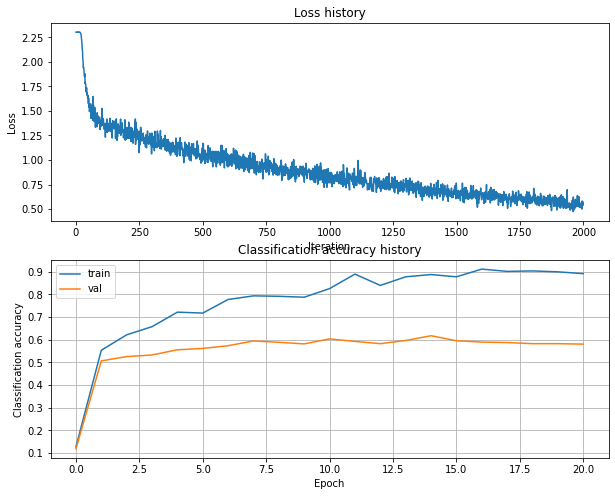

In [37]:
tuning_history, best_net, best_net_history = tuning_hyper_params(X_train_feats, y_train, X_val_feats, y_val, 2000, 500)

In [39]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.
test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.583


---
# IMPORTANT

This is the end of this question. Please do the following:

1. Click `File -> Save` to make sure the latest checkpoint of this notebook is saved to your Drive.
2. Execute the cell below to download the modified `.py` files back to your drive.

In [ ]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = []

for files in FILES_TO_SAVE:
  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
    f.write(''.join(open(files).readlines()))